In [2]:
#Run for linear regression
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
#Run for KNN
import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Run for XGB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
#from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
#from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [5]:
#for lasso

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [6]:
from scipy import stats

def remove_outliers(df):
    return df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]

In [7]:
training_records = pd.read_csv('dengue_features_train.csv')
testing_records = pd.read_csv('dengue_features_test.csv')


In [8]:
training_records_sj = training_records[training_records['city'] == 'sj'].drop('city', 1)
training_records_iq = training_records[training_records['city'] == 'iq'].drop('city', 1)
testing_records_sj = testing_records[testing_records['city'] == 'sj'].drop('city', 1)
testing_records_iq = testing_records[testing_records['city'] == 'iq'].drop('city', 1)
records_iq = pd.concat([training_records_iq, testing_records_iq], ignore_index=True)
records_sj = pd.concat([training_records_sj, testing_records_sj], ignore_index=True)
print (records_iq.describe())

              year  weekofyear     ndvi_ne     ndvi_nw     ndvi_se  \
count   676.000000  676.000000  673.000000  673.000000  673.000000   
mean   2006.500000   26.464497    0.264569    0.246152    0.252087   
std       3.777712   14.992450    0.079827    0.078274    0.076041   
min    2000.000000    1.000000    0.061729    0.035860    0.029880   
25%    2003.000000   13.750000    0.201943    0.186629    0.196557   
50%    2006.500000   26.000000    0.263643    0.241429    0.250357   
75%    2010.000000   39.000000    0.319814    0.299500    0.302300   
max    2013.000000   53.000000    0.508357    0.464800    0.538314   

          ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
count  673.000000            672.000000             672.000000   
mean     0.270362             62.778333             297.844165   
std      0.086063             34.557077               1.155995   
min      0.064183              0.000000             294.554286   
25%      0.206843             38.995000

In [9]:
records_iq['station_averaged_temp'] = records_iq[ ['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c']].interpolate().mean(axis=1)
records_sj['station_averaged_temp'] = records_sj[['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c']].interpolate().mean(axis=1)

In [10]:
records_iq.to_csv('./Files/PreProcessed-features-iq.csv', index=False)
records_sj.to_csv('./Files/PreProcessed-features-sj.csv', index=False)

In [11]:
training_targets = pd.read_csv('dengue_labels_train.csv')

In [12]:
training_targets.drop(['year'], axis=1, inplace=True)
training_targets['week_start_date'] = training_records['week_start_date']
training_targets_sj = training_targets[training_targets['city'] == 'sj'].drop('city', 1)
training_targets_iq = training_targets[training_targets['city'] == 'iq'].drop('city', 1)

In [13]:
training_targets_iq.to_csv('./Files/PreProcessed-labels-train-iq.csv', index=False)
training_targets_sj.to_csv('./Files/PreProcessed-labels-train-sj.csv', index=False)

In [14]:
records_iq = pd.read_csv(
    './Files/PreProcessed-features-iq_edit.csv', 
    parse_dates=['week_start_date'],
    index_col='week_start_date'
).interpolate()
records_sj = pd.read_csv(
    './Files/PreProcessed-features-sj_edit.csv', 
    parse_dates=['week_start_date'],
    index_col='week_start_date'
).interpolate()
labels_iq = pd.read_csv(
    './Files/PreProcessed-labels-train-iq_edit.csv',
    parse_dates=['week_start_date'],
    index_col='week_start_date'
)
labels_sj = pd.read_csv(
    './Files/PreProcessed-labels-train-sj_edit.csv',
    parse_dates=['week_start_date'],
    index_col='week_start_date'
)

In [15]:
def getPredictions(Id, totalRecords,labels,numOfTrain , period ,features):
    ##One hot encode weekofyear
    #totalRecords=remove_outliers(totalRecords)
    weeks = pd.get_dummies(totalRecords['weekofyear'], prefix='w')
    train_time , test_time = weeks[:numOfTrain].reset_index().drop('week_start_date'
                                                                 , axis=1) ,weeks[numOfTrain:].reset_index().drop('week_start_date', axis=1)
    train_cases = labels[['total_cases']].reset_index().drop('week_start_date', axis=1)
    
    ####Seasonality prediction model
    seasonal_model = LinearRegression()
    seasonal_model.fit(train_time, train_cases)
    
    seasonal_train = pd.Series(
        seasonal_model.predict(train_time).flatten()).rolling(5, min_periods=1, center=True).mean()
    
    train_trendComponent = train_cases.total_cases - seasonal_train
    
    trend = totalRecords[features].reset_index().drop('week_start_date', axis=1).rolling(period).mean()
    
    train_trend = trend[period:numOfTrain]
    test_trend = trend[numOfTrain:]
    train_remainder = train_trendComponent[period:]
    
    ####Trend prediction model
    trend_model = LinearRegression()
    trend_model.fit(train_trend, train_remainder)
    train_pred_trend = pd.Series(trend_model.predict(train_trend).flatten())

    print('Mean_absolute_error for example '+str(Id) +" - "+ str(mean_absolute_error(y_pred=train_pred_trend.values + seasonal_train[period:].values,
                    y_true=train_cases['total_cases'][period:].values)))

    predicted_seasonal = pd.Series(seasonal_model.predict(test_time).flatten())-1
    predicted_trend = pd.Series(trend_model.predict(test_trend).flatten())

    pred = (predicted_trend + predicted_seasonal).rolling(5, min_periods=1, center=True).mean().astype(int)
    return pred

In [40]:
def getPredictionsX(Id, totalRecords,labels,numOfTrain , period ,features):
    ##One hot encode weekofyear
    weeks = pd.get_dummies(totalRecords['weekofyear'], prefix='w')
    train_time , test_time = weeks[:numOfTrain].reset_index().drop('week_start_date'
                                                                 , axis=1) ,weeks[numOfTrain:].reset_index().drop('week_start_date', axis=1)
    train_cases = labels[['total_cases']].reset_index().drop('week_start_date', axis=1)
    
    
    

    seasonal_model = LinearRegression()
#     seasonal_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree',
#                                         colsample_bylevel=1, colsample_bytree=1,
#                                         gamma=0, importance_type='gain',
#                                         learning_rate=0.1, max_delta_step=0,
#                                         max_depth=3, min_child_weight=1,
#                                         missing=None, n_estimators=100, n_jobs=1,
#                                         nthread=None, objective='reg:linear',
#                                         random_state=0, reg_alpha=0,
#                                         subsample=1)
    seasonal_model.fit(train_time, train_cases)  #fit the model
    seasonal_train = pd.Series(
    seasonal_model.predict(train_time).flatten()).rolling(5, min_periods=1, center=True).mean()
    train_trendComponent = train_cases.total_cases - seasonal_train
    trend = totalRecords[features].reset_index().drop('week_start_date', axis=1).rolling(period).mean()

    train_trend = trend[period:numOfTrain]
    test_trend = trend[numOfTrain:]
    train_remainder = train_trendComponent[period:]
        
    
    #trend_model = neighbors.KNeighborsRegressor(n_neighbors = N)    
# ####Trend prediction model
#     trend_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree',
#                                             colsample_bylevel=1, colsample_bytree=1,
#                                             gamma=0, importance_type='gain',
#                                             learning_rate=0.1, max_delta_step=0,
#                                             max_depth=3, min_child_weight=1,
#                                             missing=None, n_estimators=100, n_jobs=1,
#                                             nthread=None, objective='reg:linear',
#                                             random_state=0, reg_alpha=0,
#                                             subsample=1)
    trend_model = LinearRegression()
    trend_model.fit(train_trend, train_remainder)
    train_pred_trend = pd.Series(trend_model.predict(train_trend).flatten())

    print('Mean_absolute_error for XGB'+" - "+ str(mean_absolute_error(y_pred=train_pred_trend.values + seasonal_train[period:].values,
                    y_true=train_cases['total_cases'][period:].values)))
    
    predicted_seasonal = pd.Series(seasonal_model.predict(test_time).flatten())-1
    predicted_trend = pd.Series(trend_model.predict(test_trend).flatten())
    
    pred = (predicted_trend + predicted_seasonal).rolling(20, min_periods=1, center=True).mean().astype(int)
    return pred

In [47]:
def getPredictionsK(Id, totalRecords,labels,numOfTrain , period ,features):
    #totalRecords=remove_outliers(totalRecords)
    ##One hot encode weekofyear
    weeks = pd.get_dummies(totalRecords['weekofyear'], prefix='w')
    train_time , test_time = weeks[:numOfTrain].reset_index().drop('week_start_date'
                                                                 , axis=1) ,weeks[numOfTrain:].reset_index().drop('week_start_date', axis=1)
    train_cases = labels[['total_cases']].reset_index().drop('week_start_date', axis=1)
    
    
    
    seasonal_model = neighbors.KNeighborsRegressor(n_neighbors = 20)
#     seasonal_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree',
#                                         colsample_bylevel=1, colsample_bytree=1,
#                                         gamma=0, importance_type='gain',
#                                         learning_rate=0.1, max_delta_step=0,
#                                         max_depth=3, min_child_weight=1,
#                                         missing=None, n_estimators=100, n_jobs=1,
#                                         nthread=None, objective='reg:linear',
#                                         random_state=0, reg_alpha=0,
#                                         subsample=1)

    seasonal_model.fit(train_time, train_cases)  #fit the model
    seasonal_train = pd.Series(
    seasonal_model.predict(train_time).flatten()).rolling(5, min_periods=1, center=True).mean()
    train_trendComponent = train_cases.total_cases - seasonal_train
    trend = totalRecords[features].reset_index().drop('week_start_date', axis=1).rolling(period).mean()

    train_trend = trend[period:numOfTrain]
    test_trend = trend[numOfTrain:]
    train_remainder = train_trendComponent[period:]
        
    
#     trend_model = neighbors.KNeighborsRegressor(n_neighbors = 10)  
####Trend prediction model
#     trend_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree',
#                                             colsample_bylevel=1, colsample_bytree=1,
#                                             gamma=0, importance_type='gain',
#                                             learning_rate=0.1, max_delta_step=0,
#                                             max_depth=3, min_child_weight=1,
#                                             missing=None, n_estimators=100, n_jobs=1,
#                                             nthread=None, objective='reg:linear',
#                                             random_state=0, reg_alpha=0,
#                                             subsample=1)
    trend_model = LinearRegression()
    trend_model.fit(train_trend, train_remainder)
    train_pred_trend = pd.Series(trend_model.predict(train_trend).flatten())

    print('Mean_absolute_error for K N'+" "+" - "+ str(mean_absolute_error(y_pred=train_pred_trend.values + seasonal_train[period:].values,
                    y_true=train_cases['total_cases'][period:].values)))
    
    predicted_seasonal = pd.Series(seasonal_model.predict(test_time).flatten())-1
    predicted_trend = pd.Series(trend_model.predict(test_trend).flatten())
  
    pred = (predicted_trend + predicted_seasonal).rolling(30, min_periods=1, center=True).mean().astype(int)
    return pred

In [48]:
def getPredictionsiq(Id, totalRecords,labels,numOfTrain , period ,features):
    #totalRecords=remove_outliers(totalRecords)
    ##One hot encode weekofyear
    weeks = pd.get_dummies(totalRecords['weekofyear'], prefix='w')
    train_time , test_time = weeks[:numOfTrain].reset_index().drop('week_start_date'
                                                                 , axis=1) ,weeks[numOfTrain:].reset_index().drop('week_start_date', axis=1)
    train_cases = labels[['total_cases']].reset_index().drop('week_start_date', axis=1)
    
    
    
    seasonal_model =  LinearRegression()
    #seasonal_model=linear_model.Lasso()
    
#     seasonal_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree',
#                                         colsample_bylevel=1, colsample_bytree=1,
#                                         gamma=0, importance_type='gain',
#                                         learning_rate=0.1, max_delta_step=0,
#                                         max_depth=3, min_child_weight=1,
#                                         missing=None, n_estimators=100, n_jobs=1,
#                                         nthread=None, objective='reg:linear',
#                                         random_state=0, reg_alpha=0,
#                                         subsample=1)

    seasonal_model.fit(train_time, train_cases)  #fit the model
    seasonal_train = pd.Series(
    seasonal_model.predict(train_time).flatten()).rolling(5, min_periods=1, center=True).mean()
    train_trendComponent = train_cases.total_cases - seasonal_train
    trend = totalRecords[features].reset_index().drop('week_start_date', axis=1).rolling(period).mean()

    train_trend = trend[period:numOfTrain]
    test_trend = trend[numOfTrain:]
    train_remainder = train_trendComponent[period:]
        
    
    
    trend_model = LinearRegression()
    trend_model.fit(train_trend, train_remainder)
    train_pred_trend = pd.Series(trend_model.predict(train_trend).flatten())

    print('Mean_absolute_error for K N'+" "+" - "+ str(mean_absolute_error(y_pred=train_pred_trend.values + seasonal_train[period:].values,
                    y_true=train_cases['total_cases'][period:].values)))
    
    predicted_seasonal = pd.Series(seasonal_model.predict(test_time).flatten())-1
    predicted_trend = pd.Series(trend_model.predict(test_trend).flatten())
  
    pred = (predicted_trend + predicted_seasonal).rolling(30, min_periods=1, center=True).mean().astype(int)
    return pred

In [58]:
pred_iq = getPredictionsiq(1,records_iq, labels_iq, 489,10, [
    'reanalysis_precip_amt_kg_per_m2','reanalysis_relative_humidity_percent', 'station_averaged_temp'
])
pred_sj = getPredictionsK(2,records_sj, labels_sj, 905, 10, [
    'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent','station_averaged_temp'
])

Mean_absolute_error for K N  - 5.921718475298418
Mean_absolute_error for K N  - 24.35152495210158


In [ ]:
Mean_absolute_error for K N  - 5.928853521613385
Mean_absolute_error for K N  - 24.346360315316883

In [36]:
labels_sj.head()

,weekofyear,total_cases
week_start_date,,
1990-12-03,49,4
1990-12-10,50,5
1990-12-17,51,4
1990-12-24,52,3
1991-01-01,1,6


In [20]:
labels_sj=labels_sj.reset_index('week_start_date')

             test   predicted
count  416.000000  260.000000
mean    29.192308   42.730769
std     26.338511   24.770854
min      0.000000    0.000000
25%      8.000000   21.000000
50%     19.000000   33.500000
75%     55.000000   64.250000
max     84.000000   84.000000


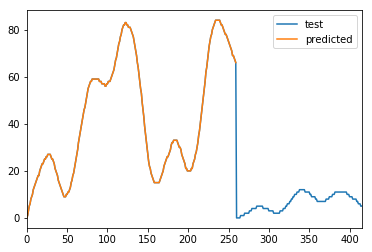

In [21]:
pdnew=pd.DataFrame()
pdnew['test']=pd.concat([pred_sj, pred_iq], ignore_index=True)
labels_sj['total_cases']
pdnew['predicted']=pred_sj
pdnew.plot()
print(pdnew.describe())

In [22]:
#Time shifting results
# for 1year
# Mean_absolute_error for K N  - 5.928853521613385
# Mean_absolute_error for K N  - 24.346360315316883
#for 10months
# Mean_absolute_error for K N  - 6.297090087463406
# Mean_absolute_error for K N  - 23.873471539021605
#for 8months
# Mean_absolute_error for K N  - 6.337037067202137
# Mean_absolute_error for K N  - 23.800682268746602


# results 1 Liner regression
# Mean_absolute_error for example 1 - 6.210521974132924
# Mean_absolute_error for example 2 - 25.249237675999417
# DataDriven Score-19.8010

# results 2 Kneighbour for Seasonal LR for trend
# Mean_absolute_error for example 1 - 6.2150369821564215
# Mean_absolute_error for example 2 - 24.980501857728154
# DataDriven Score- 19.6010

# Mean_absolute_error for K N  - 6.301117593973922
# Mean_absolute_error for K N  - 24.58401674082241

# Mean_absolute_error for K N20 10 - 6.2150369821564215
# Mean_absolute_error for K N20 10 - 24.980501857728154

# Mean_absolute_error for K N11 10 - 4.900951917461555
# Mean_absolute_error for K N20 10 - 18.849239618724045
#dont try not working score more than 27


# results 2 Xgb for Seasonal LR for trend
# Mean_absolute_error for XGB - 6.209621037814484
# Mean_absolute_error for XGB - 25.109268060571907


# results 2 Xgb for Seasonal LR for trend for IQ
# results 2 KNN for Seasonal LR for trend for SJ
# Mean_absolute_error for XGB - 6.209621037814484
# Mean_absolute_error for K N20  - 24.980501857728154
# DataDriven Score- 19.6875


# results 2 LR for Seasonal LR for trend for IQ
# results 2 KNN 20 for Seasonal LR for trend for SJ
# Mean_absolute_error for XGB - 6.210521974132924
# Mean_absolute_error for K N20  - 24.980501857728154
# DataDriven Score- 19.5865
# with roll 20
# Mean_absolute_error for K N  - 6.210521974132924
# Mean_absolute_error for K N  - 24.980501857728154
# DataDriven Score- 19.4303
# with roll 30
# Mean_absolute_error for K N  - 6.210521974132924
# Mean_absolute_error for K N  - 24.980501857728154



# Mean_absolute_error for XGB LR  - 6.209621037814484
# Mean_absolute_error for KNN KNN  - 18.849239618724045
# DataDriven Score- 27.6106 Overfits

In [59]:
pred = pd.concat([pred_sj, pred_iq], ignore_index=True).round().clip(lower=0)

In [60]:
#pred.to_csv('./Files/Prediction-seasonal-trend-prediction-KNN' + '.csv', index=False, header=False)

In [61]:
submission = pd.read_csv("submission_format.csv")

submission.total_cases = pred
print (submission.head())
submission.to_csv("time_shifted 30weeks_2.csv",index=False)

  city  year  weekofyear  total_cases
0   sj  2008          18           44
1   sj  2008          19           43
2   sj  2008          20           42
3   sj  2008          21           41
4   sj  2008          22           40
